In [49]:
import pandas as pd
import numpy as np
from  sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xgboost as xgb
import regex as re


In [14]:
df = pd.read_csv('C:\\Users\\ACER\\OneDrive - Universitas Airlangga\\Kuliah\\Learn-MLZoomCamp2023\\Learn-MLZoomCamp2023\\HomeWork\\housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [15]:
df = df[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
df['ocean_proximity'].unique()

array(['<1H OCEAN', 'INLAND'], dtype=object)

In [16]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [17]:
df = df.fillna(0)
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [18]:
df['median_house_value'] = np.log1p(df['median_house_value'].values)


In [19]:
df_full_train,x_test = train_test_split(df, test_size=0.2, random_state=1)
x_train,x_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

y_train = x_train['median_house_value'].values
y_val = x_val['median_house_value'].values
y_test = x_test['median_house_value'].values

del x_train['median_house_value']
del x_val['median_house_value']
del x_test['median_house_value']


In [20]:
dv = DictVectorizer(sparse=True)

train_dicts = x_train.to_dict(orient = 'records')
x_train = dv.fit_transform(train_dicts)

val_dict = x_val.to_dict(orient='records')
x_val = dv.transform(val_dict)

In [21]:
dt = DecisionTreeRegressor(max_depth=1)

dt.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [22]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [23]:
rf = RandomForestRegressor(n_estimators=10,random_state=1, n_jobs=-1)
rf.fit(x_train,y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [24]:
y_pred = rf.predict(x_val)
np.sqrt(mean_squared_error(y_val, y_pred))


0.24527740463893766

In [25]:
scores = []
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n,random_state=1, n_jobs=-1)
    rf.fit(x_train,y_train)
    y_pred = rf.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))

    scores.append((n,rmse))

In [ ]:
df_score = pd.DataFrame(scores, columns=['n_estimators','rmse'])
df_score['rmse']

In [34]:
df_score

,n_estimators,rmse
0,10,0.245277
1,20,0.239041
2,30,0.236995
3,40,0.235509
4,50,0.235021
5,60,0.234584
6,70,0.234466
7,80,0.234721
8,90,0.234512
9,100,0.234308


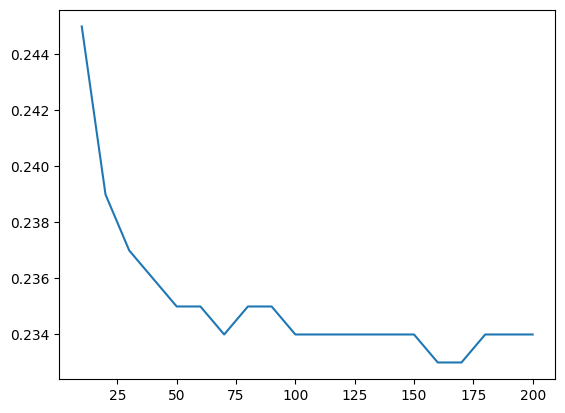

In [36]:
plt.plot(df_score.n_estimators, df_score.rmse.round(3))
plt.show()

In [30]:
scores_d = []
max_depth = [10, 15, 20, 25]

for d in max_depth :
    for n in range(10,201,10):
        rf = RandomForestRegressor(max_depth=d, n_estimators=n,random_state=1, n_jobs=-1)
        rf.fit(x_train,y_train)
        y_pred = rf.predict(x_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores_d.append((d, n,rmse))

dfd_score = pd.DataFrame(scores_d, columns=['max_depth','n_estimators','rmse'])
dfd_score

,max_depth,n_estimators,rmse
0,10,10,0.250677
1,10,20,0.247672
2,10,30,0.246434
3,10,40,0.245168
4,10,50,0.245557
...,...,...,...
75,25,160,0.233417
76,25,170,0.233433
77,25,180,0.233606
78,25,190,0.233846


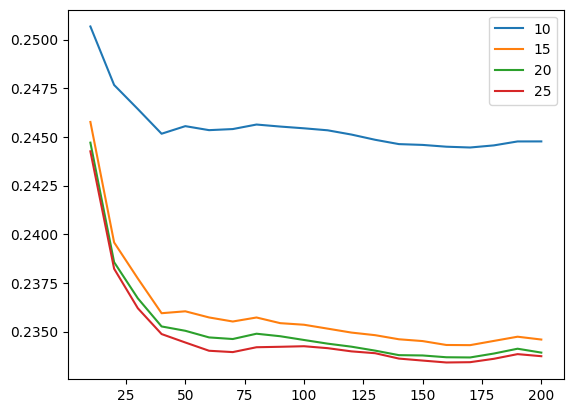

In [40]:
for d in [10, 15, 20, 25]:
    df_subset = dfd_score[dfd_score.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [41]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [43]:
rf.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

In [45]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806


In [51]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)


In [54]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [55]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)
     

In [56]:
scores['eta=0.3'] = parse_xgb_output(output)

In [57]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [58]:
scores['eta=0.1'] = parse_xgb_output(output)

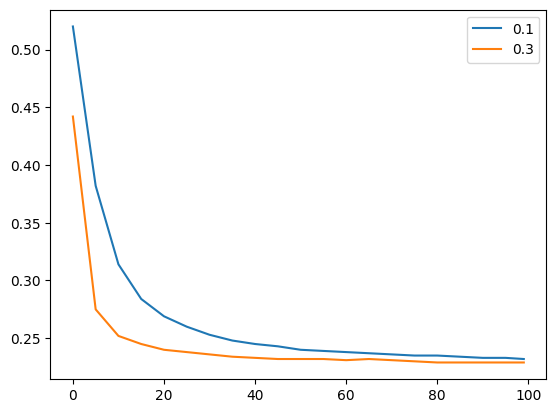

In [62]:
plt.plot(scores['eta=0.1'].num_iter.round(3), scores['eta=0.1'].val_auc.round(3),
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter.round(3), scores['eta=0.3'].val_auc.round(3),
        label='0.3')

plt.legend()
plt.show()

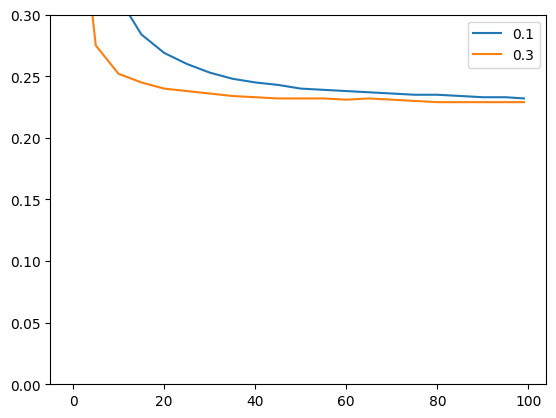

In [69]:
plt.plot(scores['eta=0.1'].num_iter.round(3), scores['eta=0.1'].val_auc.round(3),
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter.round(3), scores['eta=0.3'].val_auc.round(3),
        label='0.3')
plt.ylim(0,0.3)
plt.legend()
plt.show()

In [66]:
scores['eta=0.3'].round(3)

,num_iter,train_auc,val_auc
0,0,0.444,0.442
1,5,0.253,0.275
2,10,0.214,0.252
3,15,0.199,0.245
4,20,0.185,0.240
5,25,0.178,0.238
6,30,0.169,0.236
7,35,0.161,0.234
8,40,0.155,0.233
9,45,0.149,0.232


In [67]:
scores['eta=0.1'].round(3)

,num_iter,train_auc,val_auc
0,0,0.524,0.520
1,5,0.378,0.382
2,10,0.303,0.314
3,15,0.265,0.284
4,20,0.245,0.269
5,25,0.230,0.260
6,30,0.219,0.253
7,35,0.210,0.248
8,40,0.204,0.245
9,45,0.198,0.243
